# Interactive Face Detection Sample

This sample showcases Object Detection task applied for face recognition using sequence of neural networks.
Async API usage can improve overall frame-rate of the application, because rather than wait for inference to complete,
the application can continue operating on the host while accelerator is busy.
This sample maintains three parallel infer requests for the Age/Gender Recognition, Head Pose Estimation, and Emotions Recognition that run simultaneously.

Other sample objectives are:

*	Video as input support via OpenCV
*	Visualization of the resulting face bounding boxes from Face Detection network
*	Visualization of age/gender, head pose and emotion information for each detected face

OpenCV\* is used to draw resulting bounding boxes, labels, and other information. You can copy and paste this code without pulling Inference Engine sample helpers into your application

## How it Works

*	The application reads command line parameters and loads up to four networks depending on `-m...` options family to the Inference Engine.
*	The application gets a frame from the OpenCV's VideoCapture.
*	The application performs inference on the frame detection network.
*	The application performs three simultaneous inferences, using the Age/Gender, Head Pose and Emotions detection networks if they are specified in command line.
*	The application displays the results.

The new Async API operates with a new notion of the Infer Request that encapsulates the inputs/outputs and separates scheduling and waiting for result. For more information about Async API and the difference between Sync and Async modes performance, refer to **How it Works** and **Async API** sections in [Object Detection SSD, Async API Performance Showcase Sample](@ref InferenceEngineObjectDetectionSSDDemoAsyncApplication).


## Compiling

There are two source files: 
* [detectors.cpp](detectors.cpp) -- contains the various helper functions
* [main.cpp](main.cpp) -- contains the main loop

We have provided a Makefile for compiling the application. Run the following cell to run the make command.

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *

In [2]:
!make

make: Nothing to be done for 'all'.


This produces an executable [face_detector](). This executable takes in a number of different command line arguments.

Run the following cell to see the list: 

In [3]:
%%bash
export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/data/reference-sample-data/extension/ 
./face_detector -h

InferenceEngine: 
	API version ............ 1.4
	Build .................. 19154

interactive_face_detection [OPTION]
Options:

    -h                         Print a usage message.
    -i "<path>"                Optional. Path to an video file. Default value is "cam" to work with camera.
    -m "<path>"                Required. Path to an .xml file with a trained face detection model.
    -m_ag "<path>"             Optional. Path to an .xml file with a trained age gender model.
    -m_hp "<path>"             Optional. Path to an .xml file with a trained head pose model.
    -m_em "<path>"             Optional. Path to an .xml file with a trained emotions model.
    -m_lm "<path>"             Optional. Path to an .xml file with a trained facial landmarks model.
      -l "<absolute_path>"     Required for MKLDNN (CPU)-targeted custom layers. Absolute path to a shared library with the kernels impl.
          Or
      -c "<absolute_path>"     Required for clDNN (GPU)-targeted custom kernel

The version of the cpp file here is a slightly modified version of the faca_detector code built-in to the OpnVINO distribution.
In this version, the result is written into a output mp4 file specified by the `-o` flag. 

### Running the inference

Now we are ready to run the inference workload. In this step we will be submitting the workload as a job to the job queue.

Currently, you are on what is called a "devnode". On this system, you are alloated just one core on a large Xeon CPU. The purpose of this node is to develop code and run minimal jupyter notebooks, but it is not meant for compute jobs like deep learning inference. So we need to request additional resources from the cluster to run the inference, and this is done through the job queue.

To put an item on the job queue, we must first create a bash script that run the workload we want. Run the following cell to create bash script [face_detection_demo.sh](face_detection_demo.sh) which will be our job script. 

In [4]:
%%writefile face_detection_demo.sh
#PBS
INPUT_FILE=$1
DEVICE=$2
FP_MODEL=$3
OUTPUT_FILE=$4


if [ "$2" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/altera/aocl-pro-rte/aclrte-linux64/
    source /opt/fpga_support_files/setup_env.sh
    aocl program acl0 /opt/intel/computer_vision_sdk/bitstreams/a10_vision_design_bitstreams/5-0_PL1_FP11_MobileNet_Clamp.aocx
fi

cd $PBS_O_WORKDIR
export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/intel/computer_vision_sdk/deployment_tools/inference_engine/samples/build/intel64/Release/lib/ 
MODEL_ROOT=/opt/intel/computer_vision_sdk/deployment_tools/intel_models
./face_detector -i $INPUT_FILE -no_wait \
-m ${MODEL_ROOT}/face-detection-adas-0001/$FP_MODEL/face-detection-adas-0001.xml \
-m_hp ${MODEL_ROOT}/head-pose-estimation-adas-0001/$FP_MODEL/head-pose-estimation-adas-0001.xml \
-m_ag ${MODEL_ROOT}/age-gender-recognition-retail-0013/$FP_MODEL/age-gender-recognition-retail-0013.xml \
-m_em ${MODEL_ROOT}/emotions-recognition-retail-0003/$FP_MODEL/emotions-recognition-retail-0003.xml \
-d $DEVICE \
-o $OUTPUT_FILE

Overwriting face_detection_demo.sh


To put this script on the job queue, we use the command `qsub`.
There are two important arguments we use with this command.

First, the `-l` flag.
This flag is used to specify what type of resources to request from the cluster.
For example this can be used to request a Intel Xeon system, or it can be used to request a system with an FPGA.
The syntax is `-l nodes=1:<tag>` where `<tag>` is the descriptor tag for the resource you want.
For example, `-l nodes=1:iei-tank-xeon` will request an Intel Xeon system.
To see the list of available tags, and the number of avilable systems, run the following cell.

In [5]:
!pbsnodes | grep compnode | sort | uniq -c

     11      properties = compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,8gb,1gbe,hddl-f,iei-mustang-f100-a10,iei-tank-fpga
     15      properties = compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,8gb,1gbe,hddl-r,iei-mustang-v100-mx8
     49      properties = compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,8gb,1gbe,iei-tank-core
     12      properties = compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,8gb,1gbe,ncs,intel-ncs2
      4      properties = compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,8gb,1gbe,ncs,intel-ncs,iei-tank-movidius
     10      properties = compnode,iei,tank-870,intel-core,i5-7500t,kaby-lake,intel-hd-630,8gb,1gbe
     14      properties = compnode,iei,tank-870,intel-xeon,e3-1268l-v5,skylake,intel-hd-p530,32gb,1gbe,iei-tank-xeon
      1      properties = compnode,jwip,intel-atom,e3950,apollo-lake,intel-hd-505,4gb,1gbe
      1      properties = compnode,jwip,intel-core,i5-7500,kaby-la

Then there is the `-F` flag, which is used to pass in arguments to the job script.
The [face_detection_demo.sh](face_detection_demo.sh) takes in 2 arguments:
1) the path to the video to run inference on
2) targeted device (CPU,GPU,MYRIAD)
The job scheduler will use the contents of `-F` flag as the argument to the job script.

The following line will request an Intel Xeon system, and passes in "faces-recognition-walking.mp4 CPU" to the job script. Run the cell to submit this job. 

In [22]:
os.environ["VIDEO"] = "faces-recognition-walking.mp4"

#### Submitting to an edge compute node with an Intel CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel 
    Core i5-6500TE</a>. The inference workload will run on the CPU.#### submitting to a node with Intel Core CPU

In [23]:
print("Submitting job to Intel Core CPU...")
#Submit job to the queue
job_id_core = !qsub face_detection_demo.sh -l nodes=1:iei-tank-core -F "$VIDEO CPU FP32 results/"
print(job_id_core[0])

#Progress indicators
if job_id_core:
    progressIndicator('results/', 'i_progress_'+job_id_core[0]+'.txt', "Inference", 0, 100)

Submitting job to Intel Core CPU...
7624.c003


#### Submitting to an edge compute node with Intel Xeon CPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88178/Intel-Xeon-Processor-E3-1268L-v5-8M-Cache-2-40-GHz-">Intel 
    Xeon Processor E3-1268L v5</a>. The inference workload will run on the CPU.

In [24]:
print("Submitting job to Intel Xeon CPU...")
#Submit job to the queue
job_id_xeon = !qsub face_detection_demo.sh -l nodes=1:iei-tank-xeon -F "$VIDEO CPU FP32 results/"
print(job_id_xeon[0])

#Progress indicators
if job_id_xeon:
    progressIndicator('results/', 'i_progress_'+job_id_xeon[0]+'.txt', "Inference", 0, 100)

Submitting job to Intel Xeon CPU...
7625.c003


Here you should see a output like "{job_id}.c003", where {job_id} is a number.
This is your job ID, and this value can be used to check on the progress of the job down the line.
Furthermore, the above job script has been written so that it uses its job_id as the name of the output video.   

One bigadvantage of the Job queue system is that you may submit multiple jobs at once. 
These jobs will be run as soon as resources are available, and may all run at once if the cluster is not busy.
Here are few other "preset" jobs that for your convenience that you can run. 

#### Submitting to an edge compute node with Intel Core CPU and using the onboard Intel GPU
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.

In [25]:
print("Submitting job to Intel Core CPU with Intel GPU...")
#Submit job to the queue
job_id_gpu = !qsub face_detection_demo.sh -l nodes=1:iei-tank-core -F "$VIDEO GPU FP32 results/"
print(job_id_gpu[0])

#Progress indicators
if job_id_gpu:
    progressIndicator('results/', 'i_progress_'+job_id_gpu[0]+'.txt', "Inference", 0, 100)

Submitting job to Intel Core CPU with Intel GPU...
7626.c003


#### Submitting to an edge compute node with  IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> card installed in this node.

In [47]:
print("Submitting job to node with Intel FPGA HDDL-F...")
#Submit job to the queue
job_id_fpga = !qsub face_detection_demo.sh -l nodes=1:iei-tank-fpga -F "$VIDEO HETERO:FPGA,CPU FP32 results/"
print(job_id_fpga[0])

#Progress indicators
if job_id_fpga:
    progressIndicator('results/', 'i_progress_'+job_id_fpga[0]+'.txt', "Inference", 0, 100)

Submitting job to node with Intel FPGA HDDL-F...
7654.c003


#### Submitting to an edge compute node with Intel Movidius NCS (Neural Compute Stick)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/movidius-ncs">Intel 
    Movidius Neural Compute Stick</a> installed in this node.

In [43]:
print("Submitting job to node with Intel Movidius NCS...")
#Submit job to the queue
job_id_ncs = !qsub face_detection_demo.sh -l nodes=1:tank-870:i5-6500te:intel-ncs -F "$VIDEO MYRIAD FP16 results/"
print(job_id_ncs[0])

#Progress indicators
if job_id_ncs:
    progressIndicator('results/', 'i_progress_'+job_id_ncs[0]+'.txt', "Inference", 0, 100)

Submitting job to node with Intel Movidius NCS...
7636.c003


#### Submitting to an edge compute node with Intel NCS 2 (Neural Compute Stick 2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [46]:
print("Submitting job to node with Intel NCS2...")
#Submit job to the queue
job_id_ncs2 = !qsub face_detection_demo.sh -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "$VIDEO MYRIAD FP32 results/"
print(job_id_ncs2[0])

#Progress indicators
if job_id_ncs:
    progressIndicator('results/', 'i_progress_'+job_id_ncs2[0]+'.txt', "Inference", 0, 100)

Submitting job to node with Intel NCS2...
7648.c003


The `qstat` command is used to track the progress of the jobs. 
We have provided a utility funtion "liveQstat()" that provide a live updating GUI for you.
Run the following cell to check on the progress of your earlier jobs.

#### Submitting to an edge compute node with  IEI Mustang-V100-MX8 ( Intel® Movidius™ Myriad™ X Vision Processing Unit (VPU))
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://www.ieiworld.com/mustang-v100/en/">IEI Mustang-V100-MX8 </a>accelerator installed in this node.

In [45]:
#Submit job to the queue
job_id_vpu = !qsub face_detection_demo.sh -l nodes=1:tank-870:i5-6500te:iei-mustang-v100-mx8 -F "$VIDEO HDDL FP16 results/"
print(job_id_vpu[0]) 
#Progress indicators
if job_id_vpu:
    progressIndicator('results/', 'i_progress_'+job_id_vpu[0]+'.txt', "Inference", 0, 100)

7638.c003


#### Submitting to an edge compute node with UP Squared Grove IoT Development Kit (UP2)
In the cell below, we submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/up-squared-grove-dev-kit">UP Squared Grove IoT Development Kit</a> edge node with an <a 
    href="https://ark.intel.com/products/96488/Intel-Atom-x7-E3950-Processor-2M-Cache-up-to-2-00-GHz-">Intel Atom® x7-E3950 Processor</a>. The inference  workload will run on the integrated Intel® HD Graphics 505 card.

In [30]:
#Submit job to the queue
job_id_up2 = !qsub face_detection_demo.sh -l nodes=1:up-squared -F "$VIDEO GPU FP32 results/"
print(job_id_up2[0]) 
#Progress indicators
if job_id_up2:
    progressIndicator('results/', 'i_progress_'+job_id_up2[0]+'.txt', "Inference", 0, 100)

7631.c003


In [14]:
liveQstat()

Output(layout=Layout(border='1px solid gray', width='100%'))

Button(description='Stop', style=ButtonStyle())

Once the jobs are done. The following cell can be used to display the output. 
The videoHTML is a utility fnction provided in [demoutils.py](demoutils.py).
This takes one argument, which is the path to the video (see above for convention for the path name).

For your convenience we have stored the jobid from the above `qsub` commands, and the following cells 

In [31]:
videoHTML('IEI Tank (Intel Core CPU)', 
          ['results/output_' + job_id_core[0] + '.mp4'], 
          'results/stats_'+job_id_core[0]+'.txt')

In [32]:
videoHTML('IEI Tank Xeon (Intel Xeon CPU)',
          ['results/output_'+job_id_xeon[0]+'.mp4'],
          'results/stats_'+job_id_xeon[0]+'.txt')

In [33]:
videoHTML('IEI Intel GPU (Intel Core + Onboard GPU)', 
          ['results/output_'+job_id_gpu[0]+'.mp4'],
          'results/stats_'+job_id_gpu[0]+'.txt')

In [34]:
videoHTML('IEI Tank + IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)',
          ['results/output_'+job_id_fpga[0]+'.mp4'],
          'results/stats_'+job_id_fpga[0]+'.txt')

In [35]:
videoHTML('IEI Tank + Intel CPU + Intel Movidius NCS',
          ['results/output_'+job_id_ncs[0]+'.mp4'],
          'results/stats_'+job_id_ncs[0]+'.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'results/stats_7628.c003.txt'

In [36]:
videoHTML('IEI Tank + Intel CPU + Intel NCS2',
          ['results/output_'+job_id_ncs2[0]+'.mp4'],
          'results/stats_'+job_id_ncs2[0]+'.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'results/stats_7629.c003.txt'

In [37]:
videoHTML('IEI Tank + IEI Mustang-V100-MX8 (Intel® Movidius™ Myriad™ X Vision Processing Unit (VPU))',
          ['results/output_'+job_id_vpu[0]+'.mp4'],
          'results/stats_'+job_id_vpu[0]+'.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'results/stats_7630.c003.txt'

In [40]:
videoHTML('UP Squared Grove IoT Development Kit (UP2)',
          ['results/output_'+job_id_up2[0]+'.mp4'],
          'results/stats_'+job_id_up2[0]+'.txt')

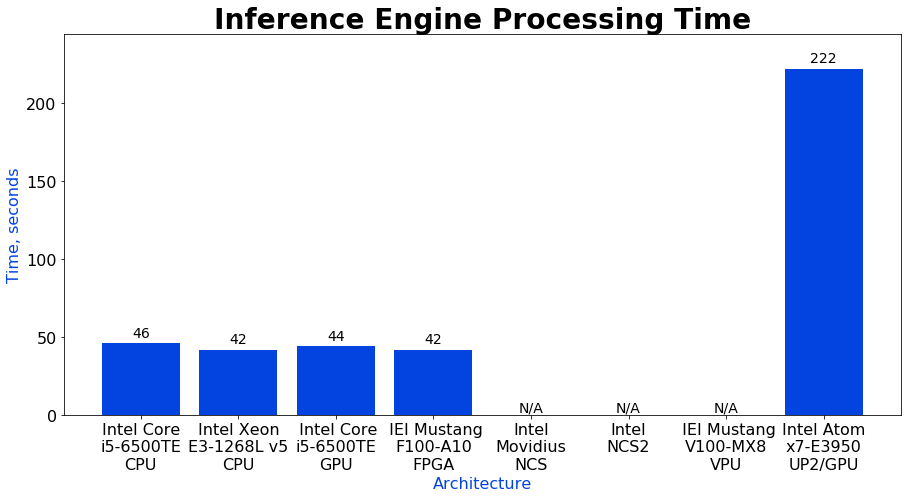

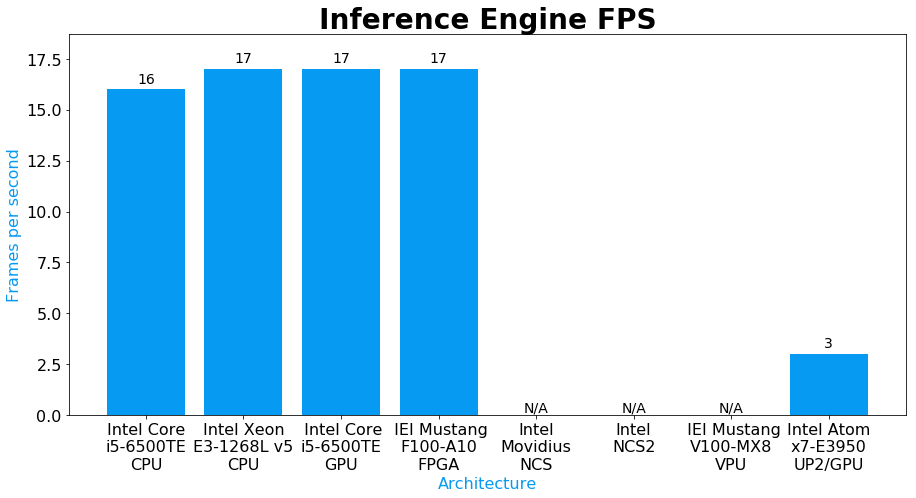

In [42]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('xeon', 'Intel Xeon\nE3-1268L v5\nCPU'),
             ('gpu', ' Intel Core\ni5-6500TE\nGPU'),
             ('fpga', ' IEI Mustang\nF100-A10\nFPGA'),
             ('ncs', 'Intel\nMovidius\nNCS'),
             ('ncs2', 'Intel\nNCS2'),
             ('vpu', ' IEI Mustang\nV100-MX8\nVPU'),
             ('up2', 'Intel Atom\nx7-E3950\nUP2/GPU')]

stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/stats_'+vars()['job_id_'+arch][0]+'.txt', a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )
summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )